In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Input, Lambda,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from google.colab import drive
import os

import cv2
import math
import random
import numpy as np
from sklearn.model_selection import GridSearchCV

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Fram Extraction

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 120, 120
SEQUENCE_LENGTH = 9
CLASSES_LIST = ["push"]
from skimage import transform

def frames_extraction(video_path):#, dirIMG, abc):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break

        # Get the dimensions of the image
        height, width, _ = frame.shape

        # Calculate the crop dimensions
        left_crop = int(width * 0.10)
        right_crop = int(width * 0.90)

        # Crop the image
        img_cropped = frame[:, left_crop:right_crop]


        resized_frame = cv2.resize(img_cropped, (IMAGE_HEIGHT, IMAGE_WIDTH),interpolation = cv2.INTER_AREA)
        RGB_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
        normalized_frame = RGB_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list
# Apply Gaussian blur to the image

def create_dataset():

    features = []
    labels = []
    video_files_paths = []

    for liste in RGB :
        cpt=0
        print(f'Extracting Data of Class: {CLASSES_LIST[RGB.index(liste)]}')
        for file_name in liste:
            cpt+=1
            video_file_path = '/content/DATA/normal/'+str(CLASSES_LIST[RGB.index(liste)])+ '/'+str(file_name)

            frames = frames_extraction(video_file_path ) #, dirIMG,abc)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(str(CLASSES_LIST[RGB.index(liste)]))
                #labels.append("normal")
                video_files_paths.append(video_file_path)
            else :
                print("nooo")
                print(file_name)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

all_features, labels, video_files_paths = create_dataset()

# Data

In [ ]:
data_train= np.load("/content/drive/MyDrive/data_train.npy")
data_val= np.load("/content/drive/MyDrive/data_val.npy")
data_test= np.load("/content/drive/MyDrive/data_test.npy")
labels_train= np.load("/content/drive/MyDrive/labels_train.npy")
labels_val= np.load("/content/drive/MyDrive/labels_val.npy")
labels_test= np.load("/content/drive/MyDrive/labels_test.npy")
OF_train= np.load("/content/drive/MyDrive/OF_train.npy")
OF_val= np.load("/content/drive/MyDrive/OF_val.npy")
OF_test= np.load("/content/drive/MyDrive/OF_test.npy")
OF_train = OF_train/255
OF_val = OF_val/255
OF_test = OF_test/255

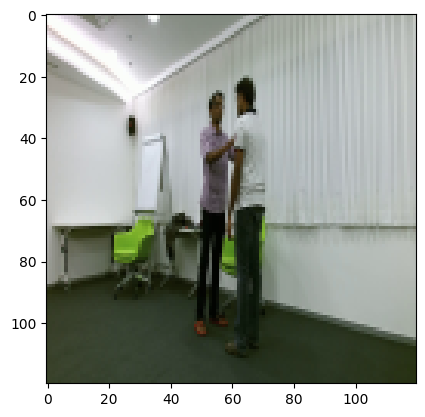

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(data_test[0, 5, :, :, :])

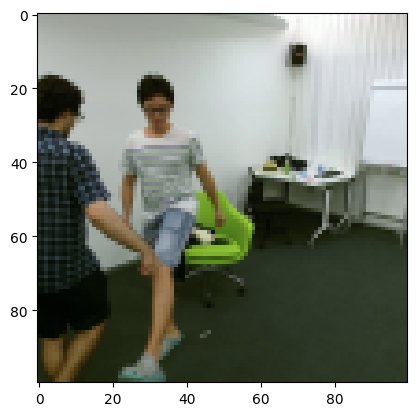

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(data_val[12, 6, :, :, :])

In [ ]:
def generate_optical_flow(all_features):
  optical_flow_frames=[]
  for i in range(len(all_features)-1):
      dtvl1 = cv2.optflow.DualTVL1OpticalFlow_create()
      flowDTVL1 = dtvl1.calc(cv2.cvtColor((all_features[i]).astype(np.uint8), cv2.COLOR_BGR2GRAY),cv2.cvtColor((all_features[i+1]).astype(np.uint8), cv2.COLOR_BGR2GRAY), None)
      x, y = flowDTVL1[..., 0], flowDTVL1[..., 1]
      mag, ang = cv2.cartToPolar(x, y)
      hsv = np.zeros((100, 100, 1), dtype = np.uint8)
      hsv[..., 0] = (cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
      #rgb = cv2.resize(hsv, (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_AREA)
      optical_flow_frames.append(hsv)

  optical_flow_stack = np.stack(optical_flow_frames, axis=0)
  return optical_flow_stack

def create_dataset():
    OF_frame_list = []
    for file_name in liste:
        OF_frame_list.append(generate_optical_flow(file_name))

    OF_frame_list=np.asarray(OF_frame_list)

    # Return the frames, class index, and video file path.
    return OF_frame_list

OF_frame_list = create_dataset()


In [ ]:
np.save("/content/drive/MyDrive/OF_write.npy", OF_frame_list)

In [ ]:
kick = np.load("/content/drive/MyDrive/OF_kicking.npy")
kick.shape

(945, 8, 100, 100, 1)

In [ ]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

code = np.array(labels)
label_encoder = LabelEncoder()
vec = label_encoder.fit_transform(code)
#one_hot_encoded_labels2 = to_categorical(vec)    #test
one_hot_encoded_labels1 = to_categorical(vec)

Train / Test data

In [ ]:
X = np.asarray(list(zip(data, OF)), dtype=object)
X_train, X_test, y_train, y_test = train_test_split(X, one_hot_encoded_labels1, test_size=0.2, stratify=one_hot_encoded_labels1)
X_train1, X_train2 = zip(*X_train)
X_test1, X_test2 = zip(*X_test)

Train / Validation data

In [ ]:
"""
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, stratify=y_test)
X_val1, X_val2 = zip(*X_val)
X_test1, X_test2, = zip(*X_test)
"""
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)
X_val1, X_val2 = zip(*X_val)
X_train1, X_train2, = zip(*X_train)

# OF + RGB


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator()
def video_data_generatorT(data, label, batch_size, OF, frames_per_clip, num_epochs):
    # get number of samples
    num_samples = data.shape[0]
    # create batches of data
    num_batches = num_samples // batch_size
    epoch = 0
    while True :
      epoch += 1
      if epoch > num_epochs:
        break
      for i in range(num_batches):
          batch_data = data[i*batch_size:(i+1)*batch_size]
          batch_labels = label[i*batch_size:(i+1)*batch_size]
          batch_OF = OF[i*batch_size:(i+1)*batch_size]

          batch_data = batch_data[:, :frames_per_clip, :, :, :]
          batch_OF = batch_OF[:, :frames_per_clip-1, :, :]

          yield [batch_data, batch_OF], batch_labels

def video_data_generator(data, label, batch_size, OF, frames_per_clip, num_epochs):####durant entrainement avec augmentation des données
    # get number of samples
    num_samples = data.shape[0]
    # create batches of data
    num_batches = num_samples // batch_size
    epoch = 0
    while True :
      epoch += 1
      if epoch > num_epochs:
        break
      for i in range(num_batches):
          batch_data = data[i*batch_size:(i+1)*batch_size]
          batch_labels = label[i*batch_size:(i+1)*batch_size]
          batch_OF = OF[i*batch_size:(i+1)*batch_size]

          batch_data = batch_data[:, :frames_per_clip, :, :, :]
          batch_OF = batch_OF[:, :frames_per_clip-1, :, :]

          for m in range(int(batch_size/2)):
            np.append(batch_labels, batch_labels[m])
            new1=[]
            new2=[]
            for j in range(frames_per_clip):
              new1.append(gen.apply_transform(batch_data[m][j], {'flip_horizontal':True}))
              if j<=(frames_per_clip-2):
                jsp = batch_OF[m][j].reshape(100, 100, 1)
                new2.append(gen.apply_transform(jsp, {'flip_horizontal':True}))
            np.append(batch_data, new1)
            np.append(batch_OF, new2)

          for m in range(int(batch_size/2), batch_size):
            np.append(batch_labels, batch_labels[m])
            new1=[]
            new2=[]
            for j in range(frames_per_clip):
              new1.append(gen.apply_transform(batch_data[m][j], {'flip_horizontal':True, 'brightness':0.7}))
              if j<=(frames_per_clip-2):
                jsp = batch_OF[m][j].reshape(100, 100, 1)
                new2.append(gen.apply_transform(jsp, {'flip_horizontal':True, 'zx':0.8}))
            np.append(batch_data, new1)
            np.append(batch_OF, new2)

          yield [batch_data, batch_OF], batch_labels

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, TimeDistributed, BatchNormalization, LSTM, GRU, LeakyReLU
from sklearn.svm import SVC
import keras
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback
from keras.losses import categorical_crossentropy

def two_stream():
  # Define input shape for RGB frames
  rgb_input_shape = (9, 100, 100, 3)
  optical_flow_input_shape = (8, 100, 100, 1)

  rgb_input = Input(shape=rgb_input_shape)
  optical_flow_input = Input(shape=optical_flow_input_shape)

  # Spatial stream (RGB frames)

  x = TimeDistributed(Conv2D(16, (3, 3), strides=(2, 2), activation='relu', padding='same'))(rgb_input)
  x = TimeDistributed(BatchNormalization())(x)

  x = TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same'))(x)
  x = TimeDistributed(BatchNormalization())(x)
  x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
  x = TimeDistributed(Dropout(0.3))(x)

  x = TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same'))(x)
  x = TimeDistributed(BatchNormalization())(x)

  x = TimeDistributed(Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same'))(x)
  x = TimeDistributed(BatchNormalization())(x)
  x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
  x = TimeDistributed(Dropout(0.3))(x)

  x = TimeDistributed(Flatten())(x)

  x = GRU(256)(x)
  x = ReLU()(x)
  x = Dropout(0.5)(x)

  # Temporal stream (optical flow images)

  y = TimeDistributed(Conv2D(16, (3, 3), strides=(2, 2), activation='relu', padding='same'))(optical_flow_input)
  y = TimeDistributed(BatchNormalization())(y)

  y = TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same'))(y)
  y = TimeDistributed(BatchNormalization())(y)
  y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(y)
  y = TimeDistributed(Dropout(0.3))(y)

  y = TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same'))(y)
  y = TimeDistributed(BatchNormalization())(y)

  y = TimeDistributed(Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same'))(y)
  y = TimeDistributed(BatchNormalization())(y)
  y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(y)
  y = TimeDistributed(Dropout(0.3))(y)

  y = TimeDistributed(Flatten())(y)

  y = GRU(256)(y)
  y = ReLU()(y)
  y = Dropout(0.5)(y)

  d = concatenate([x, y])
  d = Dense(128, activation='sigmoid')(d)
  d = Dropout(0.5)(d)
  final = Dense(6, activation='softmax')(d)
  model = Model(inputs=[rgb_input, optical_flow_input], outputs=final)

  #model.summary()

  optimizer = Adam(learning_rate=0.0001)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'], run_eagerly=True)
  model.summary()
  batch_size = 16
  frames_per_clip = 9
  num_epochs = 60
  num_classes = 6

  #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #hinge
  train_generator = video_data_generatorT(data_train, labels_train, batch_size, OF_train, frames_per_clip, num_epochs)
  checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_model11.h5', monitor='val_loss', mode='min', save_best_only=True)
  early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
  #model = two_stream(0.001, 256, 'lecun_uniform')
  model.fit(train_generator, epochs=num_epochs, steps_per_epoch=data_train.shape[0] // batch_size, callbacks=[checkpoint, early_stopping_callback], validation_data=([data_val, OF_val], labels_val))#, early_stopping_callback, validation_data=([data_val, OF_val], labels_val)

  return model

In [ ]:
model = two_stream()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 9, 100, 100  0           []                               
                                , 3)]                                                             
                                                                                                  
 input_6 (InputLayer)           [(None, 8, 100, 100  0           []                               
                                , 1)]                                                             
                                                                                                  
 time_distributed_52 (TimeDistr  (None, 9, 50, 50, 1  448        ['input_5[0][0]']                
 ibuted)                        6)                                                          

In [ ]:
loss, accuracy = model.evaluate([data_test, OF_test], labels_test)
print(loss)
print(accuracy)

36/36 [==============================] - 18s 490ms/step - loss: 0.2480 - accuracy: 0.9147
0.2479856312274933
0.9146877527236938


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, TimeDistributed, BatchNormalization, LSTM, GRU, LeakyReLU
from sklearn.svm import SVC
import keras
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback
from keras.losses import categorical_crossentropy

def two_stream():
  # Define input shape for RGB frames
  rgb_input_shape = (9, 100, 100, 3)
  optical_flow_input_shape = (8, 100, 100, 1)

  rgb_input = Input(shape=rgb_input_shape)
  optical_flow_input = Input(shape=optical_flow_input_shape)

  # Spatial stream (RGB frames)

  x = TimeDistributed(Conv2D(16, (3, 3), strides=(2, 2), activation='relu', padding='same'))(rgb_input)
  x = TimeDistributed(BatchNormalization())(x)

  x = TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same'))(x)
  x = TimeDistributed(BatchNormalization())(x)
  x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
  x = TimeDistributed(Dropout(0.3))(x)

  x = TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same'))(x)
  x = TimeDistributed(BatchNormalization())(x)

  x = TimeDistributed(Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same'))(x)
  x = TimeDistributed(BatchNormalization())(x)
  x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
  x = TimeDistributed(Dropout(0.3))(x)

  x = TimeDistributed(Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same'))(x)
  x = TimeDistributed(BatchNormalization())(x)
  x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

  x = TimeDistributed(Flatten())(x)

  x = GRU(128)(x)
  x = ReLU()(x)
  x = Dropout(0.5)(x)

  # Temporal stream (optical flow images)

  y = TimeDistributed(Conv2D(16, (3, 3), strides=(2, 2), activation='relu', padding='same'))(optical_flow_input)
  y = TimeDistributed(BatchNormalization())(y)

  y = TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same'))(y)
  y = TimeDistributed(BatchNormalization())(y)
  y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(y)
  y = TimeDistributed(Dropout(0.3))(y)

  y = TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same'))(y)
  y = TimeDistributed(BatchNormalization())(y)

  y = TimeDistributed(Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same'))(y)
  y = TimeDistributed(BatchNormalization())(y)
  y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(y)
  y = TimeDistributed(Dropout(0.3))(y)

  y = TimeDistributed(Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same'))(y)
  y = TimeDistributed(BatchNormalization())(y)
  y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(y)

  y = TimeDistributed(Flatten())(y)

  y = GRU(128)(y)
  y = ReLU()(y)
  y = Dropout(0.5)(y)

  d = concatenate([x, y])
  d = Dense(64, activation='sigmoid')(d)
  d = Dropout(0.5)(d)
  final = Dense(6, activation='softmax')(d)
  model = Model(inputs=[rgb_input, optical_flow_input], outputs=final)

  #model.summary()

  optimizer = Adam(learning_rate=0.0001)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'], run_eagerly=True)
  model.summary()
  batch_size = 16
  frames_per_clip = 9
  num_epochs = 80
  num_classes = 6

  #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #hinge
  train_generator = video_data_generator(data_train, labels_train, batch_size, OF_train, frames_per_clip, num_epochs)
  checkpoint = ModelCheckpoint('/content/drive/MyDrive/model11.h5', monitor='val_loss', mode='min', save_best_only=True)
  early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
  #model = two_stream(0.001, 256, 'lecun_uniform')
  model.fit(train_generator, epochs=num_epochs, steps_per_epoch=data_train.shape[0] // batch_size, callbacks=[checkpoint, early_stopping_callback], validation_data=([data_val, OF_val], labels_val))#, early_stopping_callback, validation_data=([data_val, OF_val], labels_val)

  return model

In [ ]:
model = two_stream()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 9, 100, 100  0           []                               
                                , 3)]                                                             
                                                                                                  
 input_8 (InputLayer)           [(None, 8, 100, 100  0           []                               
                                , 1)]                                                             
                                                                                                  
 time_distributed_96 (TimeDistr  (None, 9, 50, 50, 1  448        ['input_7[0][0]']                
 ibuted)                        6)                                                          

In [ ]:
model=tf.keras.models.load_model("/content/drive/MyDrive/model11.h5")

In [ ]:
loss, accuracy = model.evaluate([data_test, OF_test], labels_test)
print(loss)
print(accuracy)

36/36 [==============================] - 12s 309ms/step - loss: 0.1191 - accuracy: 0.9552
0.11914052069187164
0.9551845192909241


In [ ]:
from sklearn.metrics import classification_report

y_true_int = np.argmax(labels_test, axis=1)
y_pred = model.predict([data_test, OF_test])
y_pred_int = np.argmax(y_pred, axis=1)

# Assuming y_true and y_pred are your true and predicted labels
report = classification_report(y_true_int, y_pred_int, output_dict=True)

# Print the accuracy for each class
for cls in report.keys():
    if cls.isdigit():
        precision = report[cls]['precision']
        recall = report[cls]['recall']
        f1_score = report[cls]['f1-score']
        accuracy = precision
        print(f"Class {cls} Accuracy: {accuracy}")   #fall 2kick 1 push

36/36 [==============================] - 17s 459ms/step
Class 0 Accuracy: 0.9791666666666666
Class 1 Accuracy: 0.9251336898395722
Class 2 Accuracy: 0.9790575916230366
Class 3 Accuracy: 0.9414893617021277
Class 4 Accuracy: 0.9841269841269841
Class 5 Accuracy: 0.9947643979057592


In [ ]:
model=tf.keras.models.load_model("/content/drive/MyDrive/model_15.h5")
from sklearn.metrics import classification_report

y_true_int = np.argmax(labels_test, axis=1)
y_pred = model.predict([data_test, OF_test])
y_pred_int = np.argmax(y_pred, axis=1)

# Assuming y_true and y_pred are your true and predicted labels
report = classification_report(y_true_int, y_pred_int, output_dict=True)

# Print the accuracy for each class
for cls in report.keys():
    if cls.isdigit():
        precision = report[cls]['precision']
        recall = report[cls]['recall']
        f1_score = report[cls]['f1-score']
        accuracy = precision
        print(f"Class {cls} Accuracy: {accuracy}")
        print(f"Class {cls} precision: {precision}")
        print(f"Class {cls} recall: {recall}")
        print(f"Class {cls} f1_score: {f1_score}")

loss, accuracy = model.evaluate([data_test, OF_test], labels_test)
print(loss)
print(accuracy)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_int, y_pred_int)
print(cm)

25/25 [==============================] - 23s 878ms/step
Class 0 Accuracy: 1.0
Class 0 precision: 1.0
Class 0 recall: 0.98125
Class 0 f1_score: 0.9905362776025236
Class 1 Accuracy: 0.9515151515151515
Class 1 precision: 0.9515151515151515
Class 1 recall: 0.98125
Class 1 f1_score: 0.9661538461538461
Class 2 Accuracy: 0.9681528662420382
Class 2 precision: 0.9681528662420382
Class 2 recall: 0.95
Class 2 f1_score: 0.9589905362776026
Class 3 Accuracy: 0.9570552147239264
Class 3 precision: 0.9570552147239264
Class 3 recall: 0.975
Class 3 f1_score: 0.9659442724458206
Class 4 Accuracy: 0.9873417721518988
Class 4 precision: 0.9873417721518988
Class 4 recall: 0.975
Class 4 f1_score: 0.9811320754716981
25/25 [==============================] - 21s 843ms/step - loss: 0.0847 - accuracy: 0.9725
0.08469843864440918
0.9725000262260437


In [ ]:
model=tf.keras.models.load_model("/content/drive/MyDrive/best_model.h5")

In [ ]:
train_generator = video_data_generatorT(data_train, labels_train, 16, OF_train, 9, 60)

train_loss, train_accuracy = model.evaluate(train_generator)

print('Training loss:', train_loss)

12780/12780 [==============================] - 1399s 109ms/step - loss: 0.2002 - accuracy: 0.9296
Training loss: 0.20016410946846008


# **RGB**


In [ ]:
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from keras.initializers import lecun_uniform

def video_data_generator(data, label, batch_size, frames_per_clip):
    # get number of samples
    num_samples = data.shape[0]
    # create batches of data
    num_batches = num_samples // batch_size
    while True :
        for i in range(num_batches):
            batch_data = data[i*batch_size:(i+1)*batch_size]
            batch_labels = label[i*batch_size:(i+1)*batch_size]
            batch_data = batch_data[:, :frames_per_clip, :, :, :]
            yield batch_data, batch_labels


regularizer = tf.keras.regularizers.l1_l2(l1=0.001)


def build_model():
    model = Sequential()

    model.add(Conv3D(filters=8, strides=(1, 2, 2), kernel_size=(3, 3, 3), activation='relu', input_shape=(9, 100, 100, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(Conv3D(filters=32, strides=(2, 2, 2), kernel_size=(3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(1, 1, 1)))

    model.add(Conv3D(filters=64, kernel_size=(1, 3, 3), strides=(1, 2, 2), activation='relu'))
    model.add(MaxPooling3D(pool_size=(1, 1, 1)))
    model.add(Conv3D(filters=256, kernel_size=(1, 3, 3), strides=(1, 2, 2), activation='relu'))
    model.add(MaxPooling3D(pool_size=(1, 1, 1)))

    model.add(TimeDistributed(Flatten()))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(GRU(units=256))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001)))
    model.add(Dropout(0.7))

    model.add(Dense(6, activation='softmax'))
    model.summary()

    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

def build_model():
    model = Sequential()

# First Conv3D layer
    model.add(Conv3D(8, kernel_size=(3,3,3), strides=(1,2,2), activation='relu',input_shape=(9,100,100,3)))
    model.add(Conv3D(16, kernel_size=(3,3,3), strides=(1,2,2), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same'))

    model.add(Dropout(0.3))

    model.add(Conv3D(32, kernel_size=(3,3,3), strides=(1,2,2), activation='relu', padding='same'))
    model.add(Conv3D(64, kernel_size=(3,3,3), strides=(1,2,2), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same'))

    model.add(Dropout(0.3))

# Flatten the output and feed it to a Dense layer
    model.add(TimeDistributed(Flatten()))

    model.add(Dense(256, activation='relu'))

    model.add(Dense(128, activation='relu'))

    model.add(Dense(64, activation='relu'))

    model.add(Dropout(0.5))

# Output layer
    model.add(Dense(6, activation='softmax'))
    model.summary()
    optimizer = Adam(learning_rate=0.00030)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model
batch_size = 32
frames_per_clip = 9
Num_classes = 6
epochs = 100

train_generator = video_data_generator(features_train, labels_train, batch_size, frames_per_clip)

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)

model = build_model()

history = model.fit(train_generator, epochs=epochs, steps_per_epoch=features_train.shape[0] // batch_size,
                    callbacks=[early_stopping_callback],validation_data=(val, labels_val))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_22 (Conv3D)          (None, 7, 49, 49, 8)      656       
                                                                 
 conv3d_23 (Conv3D)          (None, 7, 25, 25, 16)     3472      
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 7, 13, 13, 16)    0         
 g3D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 7, 13, 13, 16)     0         
                                                                 
 conv3d_24 (Conv3D)          (None, 7, 7, 7, 32)       13856     
                                                                 
 conv3d_25 (Conv3D)          (None, 7, 4, 4, 64)       55360     
                                                      

# Model with GRU

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from tensorflow.keras.optimizers import Adam

def video_data_generator(data, label, batch_size, frames_per_clip):
    # get number of samples
    num_samples = data.shape[0]
    # create batches of data
    num_batches = num_samples // batch_size
    while True :
        for i in range(num_batches):
            batch_data = data[i*batch_size:(i+1)*batch_size]
            batch_labels = label[i*batch_size:(i+1)*batch_size]
            batch_data = batch_data[:, :frames_per_clip, :, :, :]
            yield batch_data, batch_labels

def build_model():
    model = Sequential()

    model.add(Conv3D(filters=8, strides=(1, 2, 2), kernel_size=(3, 3, 3), activation='relu', input_shape=(9, 100, 100, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(Conv3D(filters=32, strides=(2, 2, 2), kernel_size=(3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(1, 1, 1)))

    model.add(Conv3D(filters=64, kernel_size=(1, 3, 3), strides=(1, 2, 2), activation='relu'))
    model.add(MaxPooling3D(pool_size=(1, 1, 1)))
    model.add(Conv3D(filters=256, kernel_size=(1, 3, 3), strides=(1, 2, 2), activation='relu'))
    model.add(MaxPooling3D(pool_size=(1, 1, 1)))

    model.add(TimeDistributed(Flatten()))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(GRU(units=256))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001)))
    model.add(Dropout(0.7))

    model.add(Dense(6, activation='softmax'))
    model.summary()

    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model




batch_size = 32
frames_per_clip = 9
Num_classes = 6
epochs = 30

train_generator = video_data_generator(features_train, labels_train, batch_size, frames_per_clip)

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', restore_best_weights = True)

model = build_model()

history = model.fit(train_generator, epochs=epochs, steps_per_epoch=features_train.shape[0] // batch_size, callbacks=[early_stopping_callback],
                         validation_data=(val,labels_val))


# Training with diffrent with hyperparameters

In [ ]:
from keras import regularizers
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import space
from tensorflow.keras.optimizers import Adam


def video_data_generator(data, label, batch_size, frames_per_clip):
    # get number of samples
    num_samples = data.shape[0]
    # create batches of data
    num_batches = num_samples // batch_size
    while True :
        for i in range(num_batches):
            batch_data = data[i*batch_size:(i+1)*batch_size]
            batch_labels = label[i*batch_size:(i+1)*batch_size]
            batch_data = batch_data[:, :frames_per_clip, :, :, :]
            yield batch_data, batch_labels


def build_model(dense_units,learning_rate, dropout_rate):
    model = Sequential()

# First Conv3D layer
    model.add(Conv3D(32, kernel_size=(3,3,3), strides=(1,2,2), input_shape=(9,100,100,3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(1,1,1)))

    model.add(Conv3D(64, kernel_size=(3,3,3), strides=(1,2,2), activation='relu'))
    model.add(MaxPooling3D(pool_size=(1,1,1)))

    model.add(Conv3D(128, kernel_size=(3,3,3), strides=(1,2,2), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

# Flatten the output and feed it to a Dense layer
    model.add(Flatten())
    model.add(Dense(dense_units))
    model.add(Dense(dense_units/2))
    model.add(Dense(dense_units/4))
    model.add(Dropout(dropout_rate))

# Output layer
    model.add(Dense(6, activation='softmax'))

# Compile the model
    model.summary()
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model


@use_named_args([
    space.Real(1e-4, 9e-4, prior='log-uniform', name='learning_rate'),
    space.Real(0.3, 0.9, name='dropout_rate'),
    space.Integer(20,40, name='epochs'),
    space.Integer(128, 400, name='dense_units')
])

def fitness(
    learning_rate, dropout_rate, epochs,dense_units):
    print("\n\n")
    print(f"Running with hyperparameters: learning_rate={learning_rate}, dropout_rate={dropout_rate}, epochs={epochs}, dense_units={dense_units}")

    batch_size = 32
    frames_per_clip = 9
    num_classes = 6

    train_generator = video_data_generator(features_train, labels_train, batch_size, frames_per_clip)
    early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', restore_best_weights = True)

    # Create the model
    model = build_model(dense_units=dense_units,learning_rate=learning_rate, dropout_rate=dropout_rate)

    # Train the model
    history = model.fit(train_generator, epochs=epochs, steps_per_epoch=features_train.shape[0] // batch_size, callbacks=[early_stopping_callback],
                         validation_data=(val, labels_val))

    # Return the validation accuracy as the fitness score to optimize
    print("test loss &  accuracy : ")
    loss, accuracy = model.evaluate(features_test, labels_test)
    print("\n")
    return -history.history['val_loss'][-1]


# Perform the hyperparameter optimization
res_gp = gp_minimize(func=fitness,
                     dimensions=[Real(1e-4, 9e-4, prior='log-uniform'), Real(0.3,0.9), Integer(20,40),Integer(128, 400)],
                     n_calls=10,
                     n_random_starts=3,
                     verbose=1)

print(f'The best hyperparameters found are:\n{res_gp.x}\nwith an accuracy of {res_gp.fun:.4f}')




Iteration No: 1 started. Evaluating function at random point.



Running with hyperparameters: learning_rate=0.00017504958498176684, dropout_rate=0.335274270903986, epochs=32, dense_units=202
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 7, 49, 49, 32)     2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 49, 49, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 24, 24, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 5, 24, 24, 64)    0         
 3D)                                                             
                                                              

KeyboardInterrupt: ignored